# Introducrtion to Machine Learning: Assignment #3
## Submission date: 09\07\2024, 23:55.
### Topics:
- Multiclass Classification
- PAC, VCdim
- Bias vs Variance
- Cross validation
- Linear Regression
- Decision Trees

**Assignment Instruction:**

· Submissions in pairs only.

· Try to keep the code as clean, concise, and short as possible

· If you wish to work in your IDE, you can, but you **must**,  insert the script back to the matching cells of the notebook and run the code. <br/>Only the notebook will be submitted in moodle (in `.ipynb` format).

· <font color='red'>Please write your answers to question in red</font>.

**Important:** All plots, results and outputs should be included in the notebook as the cells' outputs (run all cells and do not clear the output). <br/>

**Important:** Your submission must be entirely your own. Any attempts of plagiarism (including ChatGPT) will lead to grade 0 and disciplinary actions.


## Question 1 - Multiclass SVM

You will implement and compare different multiclass methods in both separable and non separable cases.

In [41]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC


As seen in tutorials, One vs One is usually a better choice than other methods, even SKlearn uses it! <br/>
You are given a partial implementation of OvO classifier and need to complete it. Specifically:<br/>
- ```__init__(self, n_classes=2, C=1.0)``` - Init $\binom{n}{2}$ estimators, one for each pair of classes.

- ```fit(self, X, y)``` - given data and labels learns the classifiers using linear SVM. <br/>

- ```predict(self, X)``` - as learned in lectures, prediction for sample will be the majority class got most votes from all the classifiers.  Therefore, $\forall i<j$ predict who is the winner for X in the estimator $(i,j)$ and update the bins accordinly.

In [61]:
from collections import defaultdict

class OneVsOneClassifier:
    def __init__(self, n_classes=2, C=1.0):
        self.n_classes = n_classes
        self.C = C
        self.estimators = defaultdict(lambda: SVC(kernel='linear', C=self.C))

    def fit(self, X, y):
        for i in range(self.n_classes):
            for j in range(i + 1,self.n_classes):
                c_p_f = np.logical_or(y == i, y == j)
                temp_X = X[c_p_f] 
                temp_y = np.where(y[c_p_f] == i, 0, 1)
                if (i, j) not in self.estimators:
                    self.estimators[(i, j)] = SVC(kernel='linear', C=self.C)
                self.estimators[(i, j)].fit(temp_X, temp_y)

    def predict(self, X):
        scores = np.zeros((self.n_classes, len(X)))
        for i in range(self.n_classes):
            for j in range(i + 1, self.n_classes):
                if (i, j) in self.estimators:
                    predictions = self.estimators[(i, j)].predict(X)
                    scores[i, predictions == 0] += 1
                    scores[j, predictions == 1] += 1

        return np.argmax(scores, axis=0)

    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)

The data

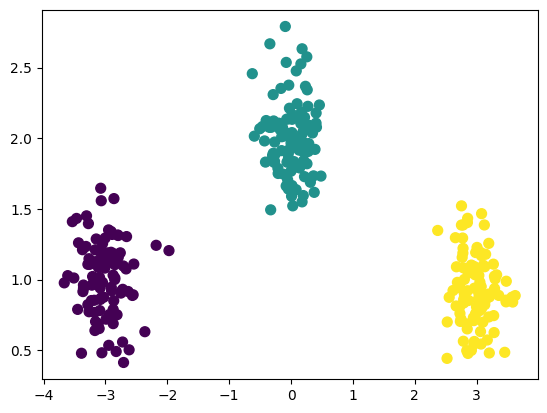

In [56]:
from sklearn.datasets import make_blobs

np.random.seed(2)
X, y = make_blobs(n_samples=300,cluster_std=.25, centers=np.array([(-3,1),(0,2),(3,1)]))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50)

This will test the classifier we just built by plotting confusion matrix and draw the decision boundaries. <br/>
Does the value of C matter? <br/>
<font color='red'>
Yes, the value of C significantly impacts the performance of a SVM.<br>
It helps balance the trade-off between minimizing training errors and preventing overfitting. <br>
A high C reduces training errors but risks overfitting, whereas a low C permits more training errors, enhancing generalization.<br>
Therefore, carefully tuning C is crucial for achieving the best model performance.
</font>

array([[100,   0,   0],
       [  0, 100,   0],
       [  0,   0, 100]], dtype=int64)

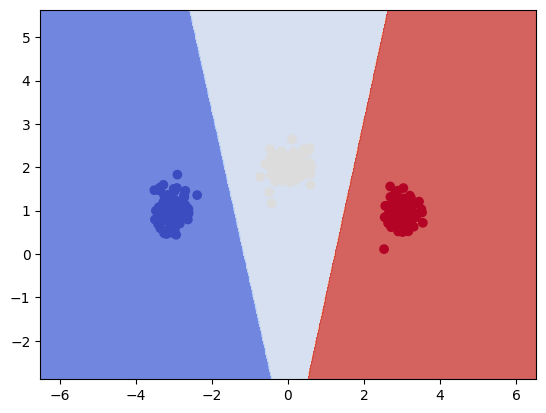

In [64]:
from sklearn import metrics

clf_onevsall = OneVsOneClassifier(n_classes=3, C=2)
clf_onevsall.fit(X,y)

# create a mesh to plot in
h = .02  # step size in the mesh
x_min, x_max = min(X[:,0])-3,max(X[:,0])+3
y_min, y_max = min(X[:,1])-3,max(X[:,1])+3
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
mesh_input = np.c_[xx.ravel(), yy.ravel()]

Z = clf_onevsall.predict(mesh_input)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)

metrics.confusion_matrix(y, clf_onevsall.predict(X))

Generate another data



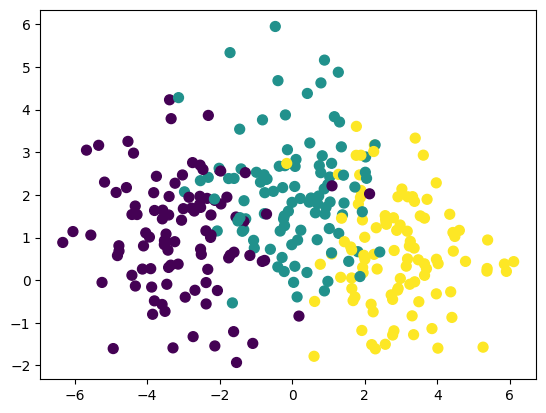

In [65]:
np.random.seed(2)
X, y = make_blobs(n_samples=300,cluster_std=1.25, centers=np.array([(-3,1),(0,2),(3,1)]))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50)

Look at the train vs test for different values of C. <br/> Justify the plot, by checking what happens as $C\rightarrow 0$, $C\rightarrow \infty$ and mid value C.<br/>
<font color='red'>
As C approaches 0, the model is heavily regularized, leading to underfitting. This is reflected in lower training and testing accuracies.

As C approaches infinity, the regularization effect diminishes, allowing the model to fit the training data very well, often resulting in overfitting.<br>
This leads to high training accuracy but lower testing accuracy due to poor generalization.

For mid-range values of C, there is a balance between regularization and model complexity. This typically results in moderate training accuracy and <br>
higher testing accuracy compared to the extremes, indicating better generalization.

</font>

100%|██████████| 4/4 [00:00<00:00, 342.77it/s]


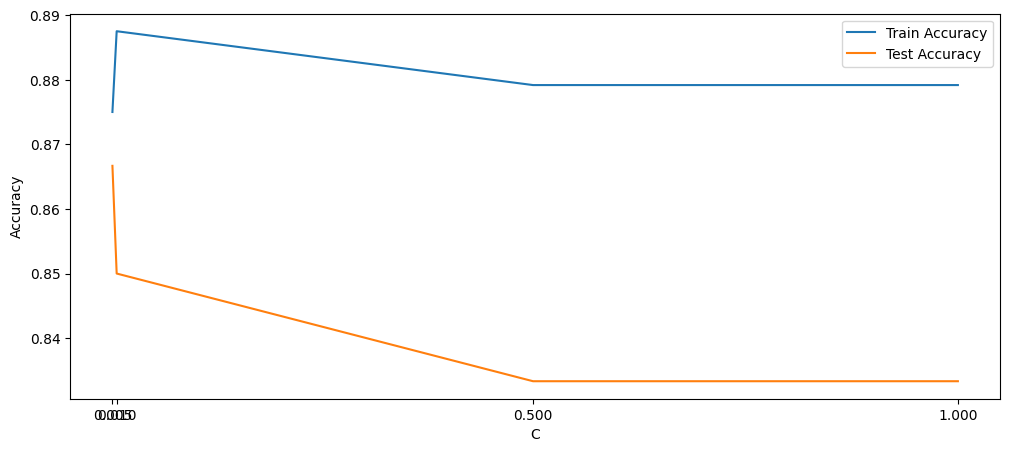

In [66]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a list of C values
C_values = [5e-3, 1e-2, 0.5, 1]

train_accuracies = []
test_accuracies = []

for C in tqdm(C_values):
    # Create a new OneVsOneClassifier instance
    clf_onevsall = OneVsOneClassifier(n_classes=3, C=C)

    # Fit the classifier on the training data
    clf_onevsall.fit(X_train, y_train)

    # Calculate the train and test accuracies
    train_accuracy = clf_onevsall.score(X_train, y_train)
    test_accuracy = clf_onevsall.score(X_test, y_test)

    # Append the accuracies to the lists
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

# Plot the train and test accuracies as a function of C

plt.figure(figsize=(12,5))
plt.plot(C_values, train_accuracies, label="Train Accuracy")
plt.plot(C_values, test_accuracies, label="Test Accuracy")
plt.xlabel("C")
plt.xticks(C_values)
plt.ylabel("Accuracy")
plt.legend()
plt.show()


Now, you will experience little bit from softmax. It uses neural networks, but you dont have to understand it. The importand part is the preidction, which is obtained by:
```
def forward(self, x):
        out = self.linear(x)
        return torch.softmax(out, dim=1)
```
Note that this is exactly that you saw - linear score $s_j$ and then applying softmax.

The best results are obtained using 300 epochs (iterations) and in each iteration the batch size is the entire data. <br/>
1. What happens as you use 100,600 epcohs compared to 300? why is that?<br>
<font color=red> 
Training for 100 epochs results in the highest test accuracy (81.67%), indicating effective learning without overfitting. At 300 epochs,<br>
 the accuracy slightly decreases to 80%, suggesting the onset of overfitting. With 600 epochs, the accuracy further drops to 78.33%, clearly<br>
  showing overfitting where the model memorizes the training data but generalizes poorly to new data. Thus, too many epochs lead to overfitting,<br>
   while fewer epochs help maintain better generalization.
</font>

2. Use 300 epochs with batch size 50 vs the entire data. How does the batch size affect the convergence of the problem?<br>
<font color=red>
Using a batch size of 50 resulted in a test accuracy of 78.33%, with the added noise in gradient updates helping to prevent overfitting but causing less stable training. In contrast, using the entire dataset as a batch size improved test accuracy to 81.67% due to more stable gradient updates, though with a risk of overfitting. While smaller batches often enhance generalization, in this case, the entire dataset batch size provided better performance.
</font>



In [94]:
num_epochs = 300
batch_size = len(X_train) // 3
#batch_size =50
#batch_size = len(X_train)
print(f"Training size is {X_train} samples and batch size is {batch_size}")

Training size is [[-1.33054229e+00  1.37828667e+00]
 [ 2.73118734e+00 -3.43785705e-01]
 [ 1.09968175e+00  2.21357665e+00]
 [-1.54809814e+00  1.48259756e+00]
 [ 4.87870562e-01  3.21938677e+00]
 [ 3.39409510e+00  3.33276026e+00]
 [-3.89906730e+00  2.70731757e-01]
 [ 3.49369153e+00 -5.04766837e-01]
 [-1.33383390e+00  1.18383607e+00]
 [-1.71204834e+00  5.33792156e+00]
 [ 1.30684748e+00  3.71127003e+00]
 [-3.52094731e+00  9.29666466e-01]
 [-3.57750669e+00  1.43861062e+00]
 [-3.29235096e-01  1.15329939e+00]
 [ 1.44065946e+00  9.03067188e-01]
 [-4.27676841e+00  1.54049463e+00]
 [ 2.41644621e+00  6.61504593e-01]
 [ 1.56056287e+00  4.42841809e-01]
 [ 2.90749628e+00 -2.33120455e-01]
 [-1.37412164e+00  1.14808669e+00]
 [ 3.97435007e+00  2.28324744e+00]
 [ 3.70338111e+00  2.72411553e-01]
 [-4.81670544e+00  5.77477778e-01]
 [ 1.92183614e+00 -1.17859113e+00]
 [-9.50142302e-03  8.32711673e-01]
 [ 3.25836237e+00  9.11404555e-01]
 [-2.52266721e+00  1.70784430e+00]
 [-9.84686925e-01  2.53094209e+00]
 [ 

In [95]:
#@title This will train the model using softmax

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

# Define the simple neural network
class SimpleNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleNN, self).__init__()
        self.linear1 = nn.Linear(input_size, output_size)
        self.linear1.weight.data.fill_(1)
        self.linear1.bias.data.fill_(1)

    def forward(self, x):
        out = self.linear1(x)
        return torch.softmax(out, dim=1)

# Set hyperparameters
input_size = X_train_tensor.shape[1]
output_size = len(torch.unique(y_train_tensor))
learning_rate = 0.01

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Instantiate the model and define the optimizer
model = SimpleNN(input_size, output_size)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode

    for inputs, targets in train_loader:
        optimizer.zero_grad()  # Clear gradients

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    #if (epoch + 1) % 10 == 0:
    #    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model on test data
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, targets in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    accuracy = correct / total
    print(f'Accuracy on test set: {accuracy:.4f}')

Accuracy on test set: 0.8000


array([[94,  4,  2],
       [19, 69, 12],
       [ 0,  9, 91]], dtype=int64)

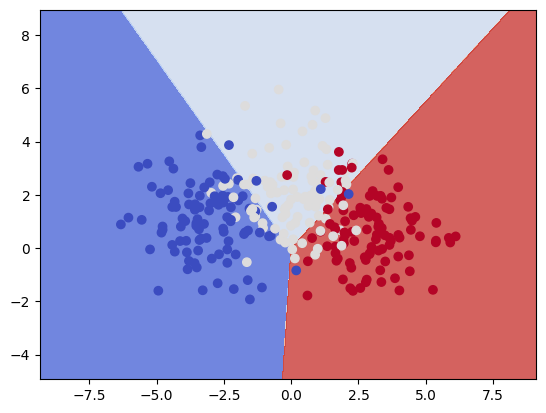

In [96]:
#@title This will plot the boundaries of the model

def predict(data):
    outputs = model(torch.tensor(data, dtype=torch.float32))
    _, predicted = torch.max(outputs, 1)
    return predicted

# create a mesh to plot in
h = .02  # step size in the mesh
x_min, x_max = min(X[:,0])-3,max(X[:,0])+3
y_min, y_max = min(X[:,1])-3,max(X[:,1])+3
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
mesh_input = np.c_[xx.ravel(), yy.ravel()]

Z = predict(mesh_input)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)

metrics.confusion_matrix(y, predict(X))

## Question 2 - Linear Regression
You are requested by the Charles Darvin himself to predict the age of abalone from physical measurements.
The dataset consists of 7 continious features that he has collected for you.

In [9]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

We define the following:
-	X, 2d matrix from size n x d which represents the training samples.
-	y, array from size n which represents the target value for the corresponding sample.

Implement the function Linreg_sol(X,y) which outputs the closed form solution for linear regression on X,y. <br/>
Don't use pinv

In [87]:
def Linreg_sol(X, y):
    X = np.hstack([np.ones((X.shape[0], 1)), X])
    best_theta = np.linalg.inv(X.T @ X) @ X.T @ y
    return best_theta

Load data from https://sharon.srworkspace.com/ml/datasets/hw3/abalone.csv

In [99]:
url='https://sharon.srworkspace.com/ml/datasets/hw3/abalone.csv'
df = pd.read_csv(url, header=None)

print(df.shape)
df.head(4)

(4177, 8)


,0,1,2,3,4,5,6,7
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10


Your tasks are:
- Convert to numpy
- Preproccess the data
- Find the weight vector and the bias

In [90]:
array = df.values
# all columns except the last one
X = array[:, :-1]
# the last column
y = array[:, -1]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

w = Linreg_sol(X_scaled, y)

print(f'The linear line is {w[1]:.2f}x1+{w[2]:.2f}x2+{w[3]:.2f}x3+{w[4]:.2f}x4+{w[5]:.2f}x5+{w[6]:.2f}x6+{w[7]:.2f}x7+{w[0]:.2f}=0')


The linear line is -0.19x1+1.33x2+0.49x3+4.53x4+-4.49x5+-1.08x6+1.19x7+9.93=0


Now, implement 'Linreg_sol_via_GD' which implement gradient descent on the linear regression problem. The stopping criterion should be based only by the iterations number recived as parameter

In [91]:
def Linreg_sol_via_GD(X, y, lr, iter_number):
    X = np.hstack([np.ones((X.shape[0], 1)), X])
    weights = np.ones(X.shape[1])
    n_samples = X.shape[0]
    for _ in range(iter_number):
        y_pred = X.dot(weights)
        error = y_pred - y
        gradient = X.T.dot(error) / n_samples
        weights -= lr * gradient
    return weights

The following code measures the number of iterations as a function of the error gap between the returned weights and the correct solution. <br/>
Conclude the complexity formula required - How many iterations do we need as a function of the error, $\varepsilon$? Make sure to include the $𝚶$ notation in your answer. <br/>
Note: This error is sometimes called 'gap'. <br/>

<font color='red'>

The number of iterations required as a function of the error $\varepsilon$ is $O\left(\frac{1}{\varepsilon}\right)$.

This relationship comes from the inequality $(\varepsilon_0 \cdot \beta^i \leq \varepsilon)$. Here, $\varepsilon_0$ represents the initial error. 
and $\beta$ represents the convergence rate, with $(0 < \beta < 1)$.<br> Taking the logarithm of both sides gives us: $(\log(\varepsilon_0) + i \cdot \log(\beta) \leq \log(\varepsilon))$.<br>
Using some algebra, we get $i = \log(\varepsilon / \varepsilon_0) / \log(\beta)$. Since $(\beta < 1)$, $(\log(\beta))$ is negative, which leads to $(i = O\left(\frac{1}{\varepsilon}\right))$. This indicates that reducing the error<br> gap requires a linear increase in the number of iterations, as shown at the plot.

Here's a detailed breakdown based on the data:

- For an error gap of approximately 0.01, about 9900 iterations are needed.
- For an error gap of approximately 0.49, about 3500 iterations are needed.
- For an error gap of approximately 1.02, about 2500 iterations are needed.
- For an error gap of approximately 1.52, about 1900 iterations are needed.

This data illustrates that as the error gap $\varepsilon$ decreases, the number of iterations required increases significantly.<br>
The trend matches the theoretical complexity of $O\left(\frac{1}{\varepsilon}\right)$, confirming the inverse relationship between the error<br>
 gap and the number of iterations.



</font>




100%|██████████| 90/90 [02:19<00:00,  1.55s/it]


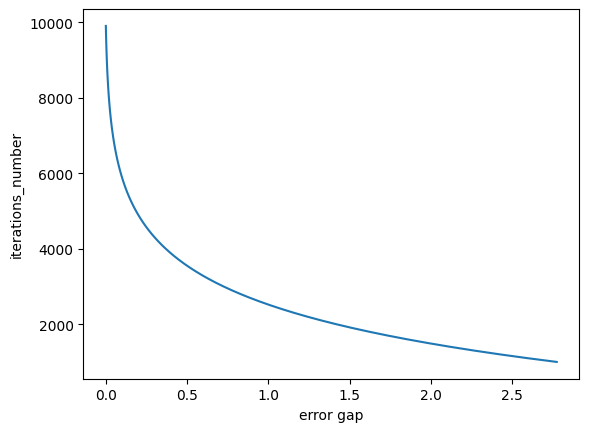

In [104]:
w_real = w

iters = np.arange(1000, 10_000, 100)
gaps = []

for iter in tqdm(iters):
    w = Linreg_sol_via_GD(X_scaled, y, lr=0.1, iter_number=iter)
    gaps.append(np.linalg.norm(w_real - w))

plt.plot(gaps, iters)
plt.ylabel("iterations_number")
plt.xlabel("error gap")
plt.show()

# # Print iteration numbers for specific error gaps
# specific_error_gaps = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5]  
# for error_gap in specific_error_gaps:
#     closest_gap = min(gaps, key=lambda x: abs(x - error_gap))
#     iter_number = iters[gaps.index(closest_gap)]
#     print(f"Error gap: {closest_gap}, Iterations needed: {iter_number}")

In the second part of the task, we will see the features dependence and try to solve it.

Calculate the the value of $\text{Cov}(X)=\frac{1}{n-1}(X-\mu)^\top (X-\mu)$? <br/>
- What can you imply from this about the features?<br>
  <font color = red>
   The features exhibit varying levels of variability and generally show minimal correlation with each other, indicating that they mostly vary independently.<br>
   Feature 4, with the highest variance at 0.2405, appears to be the most variable and potentially the most influential compared to the others.<br>
   This significant variance suggests that feature 4 could have a substantial impact on the model's outcomes. The low off-diagonal values near feature<br>
    4 also indicate that it is not strongly correlated with other features, further emphasizing its unique contribution to the variability in the dataset.
  </font>


- Can we imply something on $X^\top X$? Must its det be 0?<br>
  <font color =red>
   Given the minimal correlation among the features suggests that $X^\top X$ will display large diagonal values indicative of each feature's <br>
   independence, and minimal off-diagonal values, reflecting the lack of strong correlations between features.<br>
   The determinant of $X^\top X$ shouldn't be zero because the minimal correlation among features indicates their linear independence,<br>
   ensuring $X^\top X$ is invertible and necessary for unique linear regression solutions.

  </font>


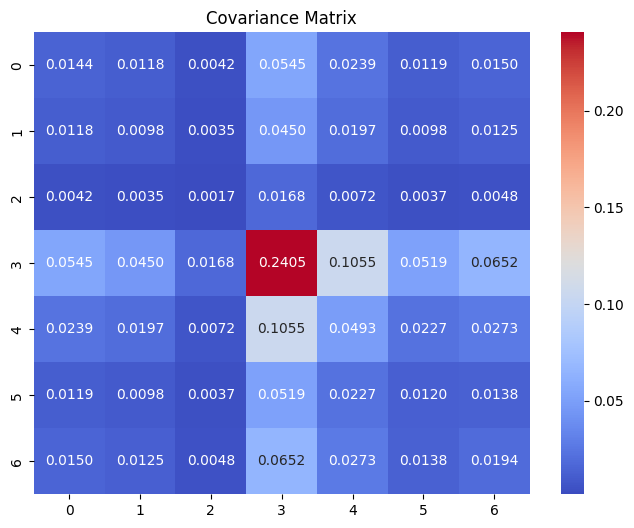

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns

mu = np.mean(X, axis=0)
n_samples = X.shape[0]

X_centered = X - mu

cov_matrix = (X_centered.T @ X_centered) / (n_samples - 1)

plt.figure(figsize=(8, 6))
sns.heatmap(cov_matrix, annot=True, cmap='coolwarm', fmt=".4f")
plt.title('Covariance Matrix')
plt.show()

Implement the solution to ridge regression using GD.

In [106]:
def Linreg_sol_Ridge(X, y, lamda):

    X = np.hstack((np.ones((X.shape[0], 1)), X))
    
    I = np.eye(X.shape[1])
    I[0, 0] = 0  
    weights = np.linalg.inv(X.T @ X + lamda * I) @ (X.T @ y)
    
    return weights


The following code measures the mse error as function of the regularization hyperparameter lamda. <br/>Explain the origin to the mse' behaviour as function of lamda in this problem. <br/>
<font color='red'>
As shown in the plot, we can see that the relationship between lambda and error is positive. As lamda increases, the error increases.<br>
This occurs because higher values of lamda impose a stronger penalty on the weights, which excessively simplifies the model and leads to underfitting.<br>
As a result, the model becomes too rigid to capture the underlying patterns in the data, thus increasing the error. Therefore, selecting an optimal<br> 
lamda is essential to strike a balance between overfitting and underfitting, ensuring the model is neither too complex nor too simple.<br>
This balance allows the model to generalize well to new, unseen data.

</font>

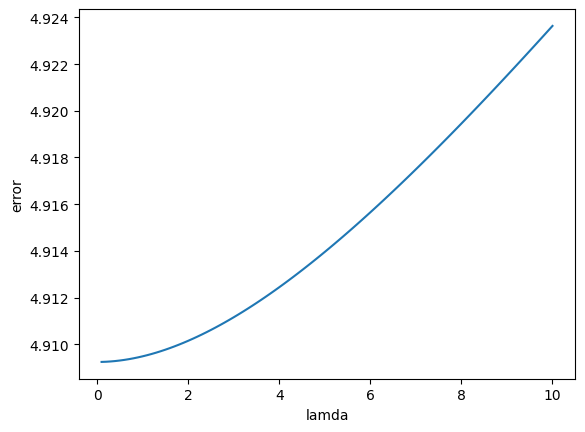

In [107]:
mses = []
lamdas = np.arange(0.1, 10.1, 0.1)

for lamda in lamdas:

    w = Linreg_sol_Ridge(X_scaled, y, lamda)

    preds = np.dot(np.hstack([np.ones((X_scaled.shape[0], 1)), X_scaled]), w)
    mses.append(np.mean((preds - y) ** 2))

plt.plot(lamdas, mses)
plt.ylabel("error")
plt.xlabel("lamda")
plt.show()

## Question 3 - Decision tree

Recall the wine dataset from hw1, where we classified wine types based on their physical and chemical properties. You will do it, but this time with decision trees!

In [1]:
# Import libraries
import numpy as np
import pandas as pd

In [2]:
# Load the data, print the first rows
data = pd.read_csv('https://sharon.srworkspace.com/ml/datasets/hw1/wine.data.csv')
data.head(3)

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline,Class
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1


Complete this missing implementation of the following functions:
- ```calculate_entropy(self, data)``` – given data, compute the entropy, where the distribution is over its labels (target class).
- ```calculate_information_gain(self, data, feature)``` – given data and specific feature, compute the information gain given by selecting that feature.

Algorithm: The data is continuous, so create 10 thresholds between the min and max values of that feature. For each threshold, split to left tree and right tree and calculate the gain. Choose the threshold which gives the highest gain, along with the gain itself (to later compare between features) <br/>

Tip: To split the tree (represented by data df), use filter_data.
For example, when calculating the gain of 'skew' with threshold 0.5, you can create the left tree by use ```filter_data(data, 'skew', '0.5', left=True)``` to obtain only those samples.

In [3]:
# Define the ID3 decision tree class
class DecisionTree:
	# def __init__(self):
	# 	self.tree = {}
	
	def __init__(self, max_depth=np.inf):
		self.tree = {}
		self.max_depth = max_depth

	def calculate_entropy(self, data):
		labels = data.iloc[:, -1]
		# Implement here
		unique_labels, label_counts = np.unique(labels, return_counts=True)
		entropy = 0
		for count in label_counts:
			probability = count / len(labels)
			entropy -= probability * np.log2(probability)
		return entropy

		
	def calculate_information_gain(self, data, feature):
		total_entropy = self.calculate_entropy(data)
		information_gain = total_entropy

		values = np.linspace(data[feature].min(), data[feature].max(), num=10) # generate 10 thresholds
		best_treshold = None
		best_gain = 0
		
		for value in values:
			# Implement here
			R_Data = self.filter_data(data, feature, value, left=False) 
			L_Data = self.filter_data(data, feature, value, left=True) 
			
			if len(R_Data) == 0 or len(L_Data) == 0:
				continue

			# Calculate weights
			R_Weight = len(R_Data) / len(data)
			L_Weight = len(L_Data) / len(data)
			
            # Calculate entropies
			R_Entropy = self.calculate_entropy(R_Data)
			L_Entropy = self.calculate_entropy(L_Data)

			current_gain = total_entropy - ((L_Weight * L_Entropy) + (R_Weight * R_Entropy))
			
			if current_gain > best_gain:
				best_gain = current_gain
				best_treshold = value
		return best_gain, best_treshold

	def filter_data(self, data, feature, value, left=True):
		if left:
			return data[data[feature] <= value].drop(feature, axis=1)
		else:
			return data[data[feature] > value].drop(feature, axis=1)

	def create_tree(self, data, depth=0):
		# Recursive function to create the decision tree
		labels = data.iloc[:, -1]

		# Base case: if all labels are the same, return the label
		if len(np.unique(labels)) == 1:
			return list(labels)[0]

		features = data.columns.tolist()[:-1]
		# Base case: if there are no features left to split on, return the majority label
		# and check if the maximum depth has been reached.
		if len(features) == 0 or depth == self.max_depth:
			unique_labels, label_counts = np.unique(labels, return_counts=True)
			majority_label = unique_labels[label_counts.argmax()]
			return majority_label

		selected_feature = None
		best_gain = 0
		best_treshold = None

		for feature in features:
			gain, treshold = self.calculate_information_gain(data, feature)
			if gain >= best_gain:
				selected_feature = feature
				best_treshold = treshold
				best_gain = gain

		# Create the tree node
		tree_node = {}
		tree_node[(selected_feature, f"<={best_treshold}")] = self.create_tree(self.filter_data(data, selected_feature, best_treshold, left=True), depth+1)
		tree_node[(selected_feature, f">{best_treshold}")] = self.create_tree(self.filter_data(data, selected_feature, best_treshold, left=False), depth+1)

		# check if can unite them.
		if not isinstance(tree_node[(selected_feature, f"<={best_treshold}")], dict) and \
				not isinstance(tree_node[(selected_feature, f">{best_treshold}")], dict):
			if tree_node[(selected_feature, f"<={best_treshold}")] == tree_node[(selected_feature, f">{best_treshold}")]:
				return tree_node[(selected_feature, f"<={best_treshold}")]

		return tree_node

	def fit(self, data):
		self.tree = self.create_tree(data)

	def predict(self, X):
		X = [row[1] for row in X.iterrows()]

		# Predict the labels for new data points
		predictions = []

		for row in X:
			current_node = self.tree
			while isinstance(current_node, dict):
				split_condition = next(iter(current_node))
				feature, value = split_condition
				treshold = float(value[2:])
				if row[feature] <= treshold:
					current_node = current_node[feature, f"<={treshold}"]
				else:
					current_node = current_node[feature, f">{treshold}"]
			predictions.append(current_node)

		return predictions

	def _plot(self, tree, indent):
		depth = 1
		for key, value in tree.items():
			if isinstance(value, dict):
				print(" " * indent + str(key) + ":")
				depth = max(depth, 1 + self._plot(value, indent + 2))
			else:
				print(" " * indent + str(key) + ": " + str(value))
		return depth

	def plot(self):
		depth = self._plot(self.tree, 0)
		print(f'depth is {depth}')

You are ready - define DecisionTree, fit it on the entire data and plot the tree. <br/>
The depth of the tree should be 5

In [4]:
# Implement here
DecTree = DecisionTree()
DecTree.fit(data)
DecTree.plot()

('Flavanoids', '<=1.3933333333333335'):
  ('Color intensity', '<=4.405555555555556'):
    ('Hue', '<=0.9022222222222223'):
      ('Proline', '<=372.0'): 2
      ('Proline', '>372.0'): 3
    ('Hue', '>0.9022222222222223'):
      ('Malic acid', '<=3.167777777777778'): 2
      ('Malic acid', '>3.167777777777778'): 3
  ('Color intensity', '>4.405555555555556'): 3
('Flavanoids', '>1.3933333333333335'):
  ('Proline', '<=745.3333333333333'):
    ('Alcohol', '<=13.231111111111112'): 2
    ('Alcohol', '>13.231111111111112'):
      ('Color intensity', '<=3.96'): 2
      ('Color intensity', '>3.96'):
        ('OD280/OD315 of diluted wines', '<=1.3'): 3
        ('OD280/OD315 of diluted wines', '>1.3'): 1
  ('Proline', '>745.3333333333333'):
    ('Alcohol', '<=12.597777777777779'): 2
    ('Alcohol', '>12.597777777777779'):
      ('Color intensity', '<=3.35'): 2
      ('Color intensity', '>3.35'): 1
depth is 5


The decision tree is pretty large (depth is 5). To solve this, lets modify our DecisionTree: <br/>
```
def __init__(self, max_depth=np.inf):
        self.tree = {}
        self.max_depth = max_depth
```

Modify the rest of the code to stop growing after max_depth. <br/>
Hint: When reached to max_depth, should we continue splitting? Which category will be best to be selected?


Using 10 thresholds, compare using max_depth=2 and max_depth=4. Based on the results, which depth is better for our problem in term of ML? <br/>
<font color='red'>
As we can see, both models have the same test accuracy, which is 88.88%, but max_depth=4 has higher training accuracy compared to max_depth=2.<br>
This indicates that max_depth=4 is overfitting the training data, as it does not improve test accuracy. Therefore, in terms of machine learning,<br>
max_depth=2 is the better choice as it provides a better balance between model complexity and generalization.
</font>

In [6]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.2, random_state=42)

for depth in [2, 4]:
  print(f"------------ max_depth={depth} ------------")
  # Implement here
  DecTree = DecisionTree(max_depth=depth)
  DecTree.fit(train)

  train_pred = DecTree.predict(train)
  acc = np.sum(train.iloc[:, -1] == train_pred) / len(train)

  print(f'Training accuracy is {acc}')

  # Implement here
  test_pred = DecTree.predict(test)
  acc = np.sum(test.iloc[:, -1] == test_pred) / len(test)

  print(f'Test accuracy is {acc}')
  print()

------------ max_depth=2 ------------
Training accuracy is 0.9225352112676056
Test accuracy is 0.8888888888888888

------------ max_depth=4 ------------
Training accuracy is 0.9859154929577465
Test accuracy is 0.8888888888888888



Now, use KFold (as seen in tutorials) for a cross validation search to the best depth for the tree.

100%|██████████| 5/5 [00:14<00:00,  2.86s/it]


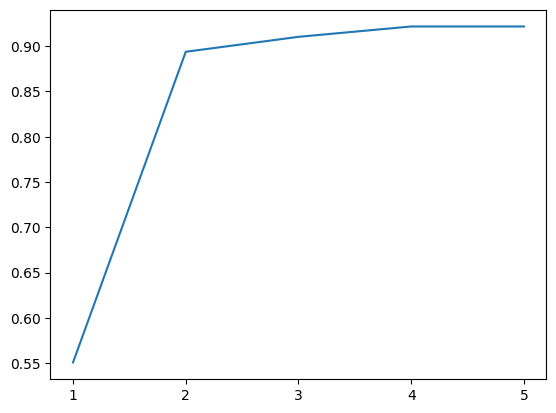

In [13]:
from sklearn.model_selection import KFold
from tqdm import tqdm
import matplotlib.pyplot as plt

kf = KFold(n_splits=5, shuffle=True, random_state=42)
accs = []

for depth in tqdm(range(1,6)):
    # Implement here
    F_accuracies = []

    for train_index, test_index in kf.split(data):
        train, test = data.iloc[train_index], data.iloc[test_index]

        dt = DecisionTree(max_depth=depth)
        dt.fit(train)

        test_accuracy = np.sum(test.iloc[:, -1] == (dt.predict(test))) / len(test)

        F_accuracies.append(test_accuracy)

    mean_accuracy = np.mean(F_accuracies)
    accs.append(mean_accuracy)

plt.plot(range(1,6), accs)
plt.xticks(range(1,6))
plt.show()

Use that depth and print the test score. Is it better generalizer than the first one? What do you conclude about the tuning proccess using validation? (answer to yourselves).

## Question 4 - PAC, Bias vs Variance
See attached pdf in moodle assignment!

## Question 5 - Polynomial regression - 5 pts bonus
In this problem you will extend regression to fit nonlinear functions.<br/>
The dataset contains one feature (x) and continiuos prediction (y).

In [1]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial

In [2]:
#@title Load data

import requests
from io import BytesIO

def load_npy_file(url):
  response = requests.get(url)
  if response.status_code == 200:
    npy_data = np.load(BytesIO(response.content), allow_pickle=True).item()
    return npy_data
  else:
    return None

In [3]:
data_dict = load_npy_file('https://sharon.srworkspace.com/ml/datasets/hw3/linreg_data_2d.npy')

x_train = data_dict['x_train']
y_train = data_dict['y_train']
x_test = data_dict['x_test']
y_test = data_dict['y_test']

Look at the plot of the training data. What do you think was the function generated the data? <br/>
<font color='red'>
The plot of the training data shows a non-linear pattern with two distinct peaks, indicating a bimodal distribution.<br> 
This suggests the data is generated by a combination of two overlapping Gaussian distributions. 
</font>

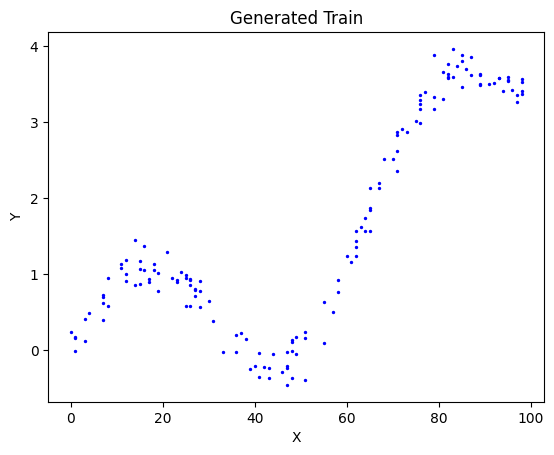

In [4]:
plt.scatter(x_train, y_train, color='blue', s=2)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Generated Train')
plt.show()

We will assume the polynomial regression problem of the following form:
$$ y=a_0+a_1x+a_2x^2+...+a_dx^d $$
The function ```get_solution``` will find the cofficients, similarly to methods done in simple linear regression. <br/>
The function ```calc``` will recieve a new sample and the cofficients found, and will predict the output.





In [5]:
def get_solution(X, y, degree=2):
    X = np.asarray(X).flatten()
    y = np.asarray(y).flatten()
    coefficients = np.polyfit(X, y, degree)
    return coefficients

def calc(x, coefs):
    return np.polyval(coefs, x)

Running the current code with $d=1$ yields a simple regressor.
- Which $d$ works best?<br>
<font color =red>
After performing cross-validation for different degrees, we found that the best polynomial degree for fitting the data is d=8.<br>
On the validation set, we observed that the polynomial degree d=8 yielded the lowest MSE. 
</font>

- According to your previous answer, which $d$ <u>is expected</u> to work the best?<br>
<font color =red> We expected a higher-degree polynomial to fit the data best, After performing cross-validation, we found that d=8<br>
 had the lowest MSE, confirming it as the optimal degree.
</font>
- Try to explain what happens when you try $d+1$ and why? Was the solver you implemented enough?<br>
<font color=red>
When increasing the polynomial degree from $d$ to $d+1$, the model may begin to overfit the data.<br>
As we see from the cross-validation results, as the polynomial degree increases from 1 to 8, the MSE decreases significantly, <br>
indicating that higher-degree polynomials fit the data better. Degree 8 is the optimal degree that balances fitting the data well <br>
without overfitting. Increasing the degree above 8 results in a slight increase in MSE.<br>
The solver using np.polyfit and np.polyval was sufficient. It effectively identified the optimal polynomial degree by computing<br>
the polynomial coefficients for each degree and evaluating their performance using MSE, ultimately finding that degree 8 was optimal.
</font>



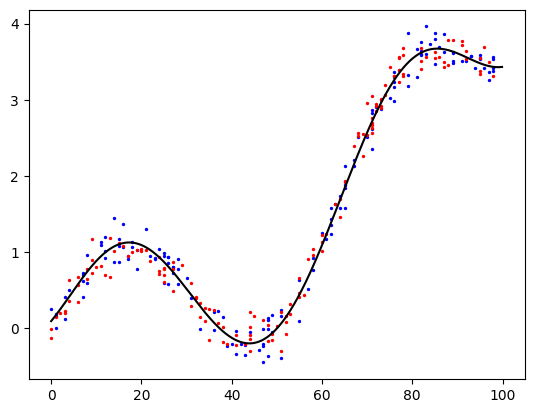

In [6]:
xx = np.arange(0, 100, 0.1)
yy = []

weights = get_solution(x_train, y_train, 8)

for samp in xx:
  yy.append(calc(samp, weights))

plt.scatter(x_train, y_train, color='blue', s=2, label='train')
plt.scatter(x_test, y_test, color='red', s=2, label='test')
plt.plot(xx, yy, color='black')
plt.show()


# Validation Error For Different Ploynomical Degrees

# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import mean_squared_error
# from sklearn.model_selection import train_test_split

# x_train = np.array(x_train).flatten()
# y_train = np.array(y_train).flatten()

# X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# degrees = range(1, 15)  # Trying polynomial degrees from 1 to 9
# errors = []

# for d in degrees:
#     coefficients = np.polyfit(X_train, y_train, d)
#     y_pred = np.polyval(coefficients, X_val)
#     mse = mean_squared_error(y_val, y_pred)
#     errors.append(mse)

#     print(f"Degree {d}: MSE = {mse}")

# best_degree = degrees[np.argmin(errors)]
# print(f"\nThe best polynomial degree is: {best_degree}")

# plt.plot(degrees, errors, marker='o')
# plt.xlabel('Polynomial Degree')
# plt.ylabel('Mean Squared Error')
# plt.title('Validation Error for Different Polynomial Degrees')
# plt.show()